In [2]:
# conda activate chronocell

import os
import sys
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [3]:
random_seed = 0

In [51]:
# Splicing rate
splicing_rate = 0.5 # (units hour^-1)
beta_mu = np.log(splicing_rate)
beta_sd = 0.5

# Transcription rate
median_transcription_rate = 2 # mRNAs/hour Fig. 2
alpha_mu = np.log(median_transcription_rate)
alpha_sd = 1

# Translation rate
median_transl_rate = 140 # proteins/mRNA*hour Fig. 2
transl_rate_mu = np.log(median_transl_rate)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9 
rna_deg_rate = np.log(2) / rna_median_half_life 
gamma_mu = np.log(rna_deg_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
protein_deg_rate = np.log(2) / protein_median_half_life
protein_deg_rate_mu = np.log(protein_deg_rate) # Median of lognormal
protein_deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [52]:
# Simulate data

n = 1000 # No. cells per lineage
p = 200 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 3, 6)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, protein_deg_rate_mu, protein_deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)
P_observed, P = simulate_protein_from_RNA(Y_observed, topo, true_t, true_l, phi, random_seed=random_seed)

In [53]:
Y_observed[:, :, 0]

array([[15, 19,  3, ...,  0,  3,  6],
       [12, 11,  1, ...,  1,  3,  5],
       [12, 18,  1, ...,  1,  4,  6],
       ...,
       [ 7,  0, 13, ...,  2,  7,  6],
       [10,  5,  8, ...,  0,  8,  0],
       [19,  2,  9, ...,  2,  6,  1]])

In [54]:
Y_observed[:, :, 1]

array([[115, 110,  22, ...,  10,  23,  24],
       [113,  90,  28, ...,  12,  43,  30],
       [103,  99,  25, ...,   9,  32,  19],
       ...,
       [116,  68,  33, ...,  10,  27,  16],
       [122,  73,  42, ...,  12,  48,  14],
       [113,  70,  36, ...,  11,  40,  13]])

In [55]:
np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])

/tmp/ipykernel_3332566/845268906.py:1: RuntimeWarning: divide by zero encountered in divide
  np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])
/tmp/ipykernel_3332566/845268906.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])


np.float64(0.16666666666666666)

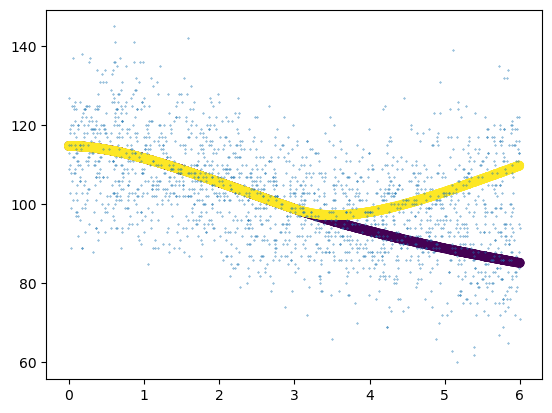

In [57]:
idx = 0
plt.scatter(true_t, Y[:, idx, 1], c=true_l)
plt.scatter(true_t, Y_observed[:, idx, 1], s=.1)

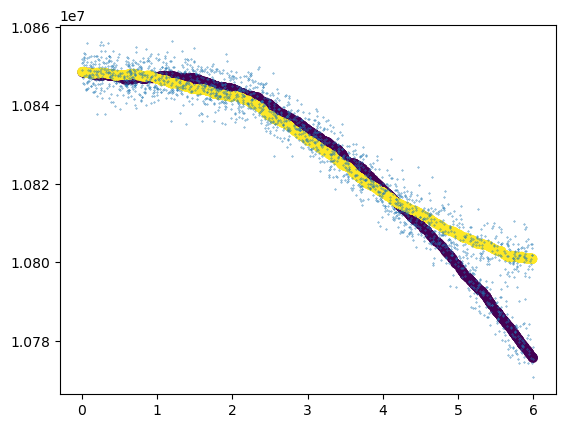

In [58]:
plt.scatter(true_t, P[:, idx], c=true_l)
plt.scatter(true_t, P_observed[:, idx], s=.1)

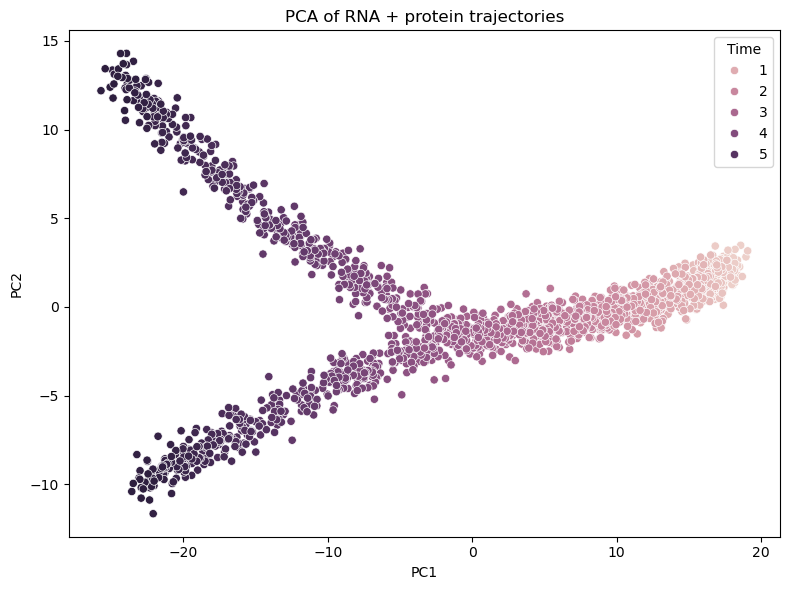

In [46]:
# PCA on cells 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = stats.zscore(Y_observed[:,:,1])
P_norm = stats.zscore(P_observed)

# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=1)
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

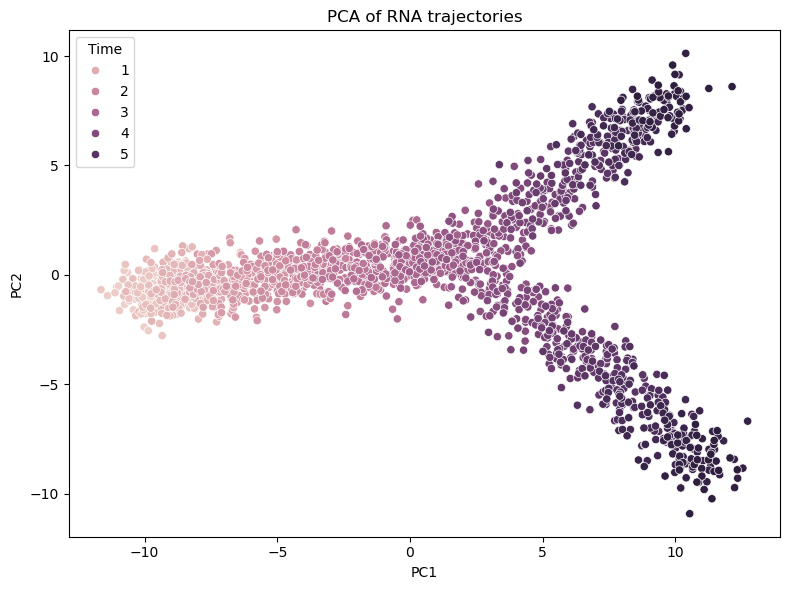

In [47]:
# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = Y_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

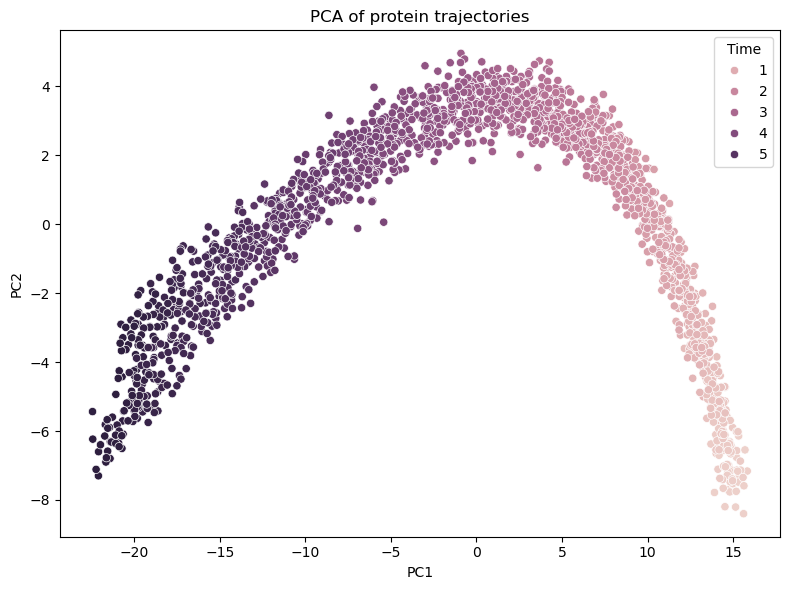

In [48]:
# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = P_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

# === Step 3: Clustering ===
meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

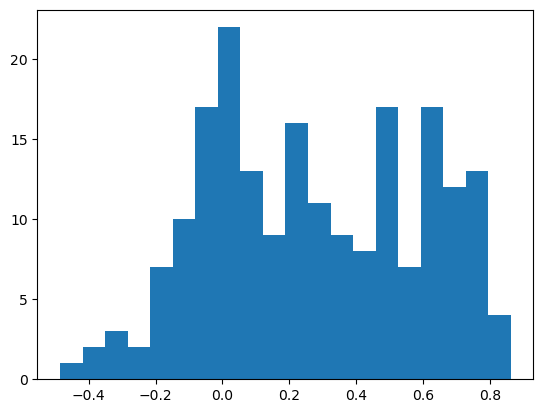

In [49]:
# theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)

rows = []
for i in range(p):
    y_i = Y_observed[:, i, 1]
    p_i = P_observed[:,i]
   
    steady_state = theta[i, 0]
    alpha_vals = theta[i, 1:-2]  # all columns after steady_state up to beta
    beta = theta[i, -2]
    gamma = theta[i, -1]
     
    row = {
        'Cor': np.corrcoef(y_i, p_i)[0, 1],
        'Steady_state': steady_state,
        'Beta': beta,
        'Gamma': gamma,
        'Translation_rate': phi[i, 0],
        'Degradation_rate': phi[i, -1]
    }
    
    for j, val in enumerate(alpha_vals, 1):
        row[f'Alpha {j}'] = val
    
    rows.append(row)

data = pd.DataFrame(rows)

param_cols = data.columns.values[1:data.shape[0]]

plt.hist(data['Cor'], bins=20);

In [20]:
data.sort_values(by="Cor")

,Cor,Steady_state,Beta,Gamma,Translation_rate,Degradation_rate,Alpha 1,Alpha 2,Alpha 3
111,-0.414736,6.773234,0.708930,0.144547,346.432184,0.075885,2.514411,4.457382,1.075229
197,-0.414593,0.342870,1.497461,0.057233,318.985796,0.083451,1.281428,0.625944,1.270349
51,-0.401442,4.728362,0.802278,0.049266,206.137809,0.006353,0.494846,2.432991,1.191742
103,-0.328595,0.934449,1.571186,0.051742,369.089488,0.005432,1.007881,7.199688,2.523931
3,-0.266565,3.644133,1.174763,0.081156,1316.241521,0.040266,1.922749,2.653671,2.376800
...,...,...,...,...,...,...,...,...,...
31,0.790480,0.424580,2.351925,0.082505,204.344019,0.007189,0.732186,0.550328,5.404203
54,0.814153,2.306597,0.852445,0.375968,136.109566,0.042517,3.427892,22.468240,2.249115
84,0.825745,0.354034,0.975913,0.063017,620.108595,0.023153,3.217047,1.034087,10.773402
36,0.848665,23.191301,0.934741,0.126050,479.111383,0.141787,5.502002,0.858825,6.538114


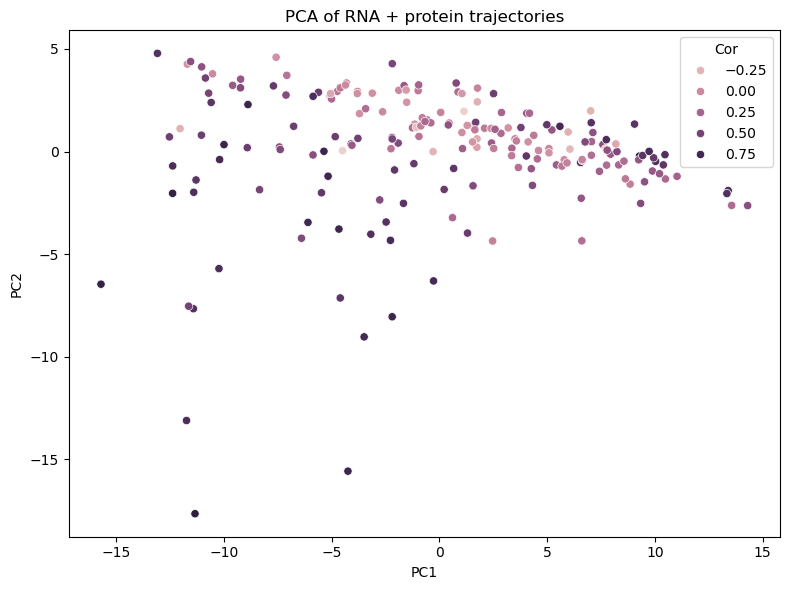

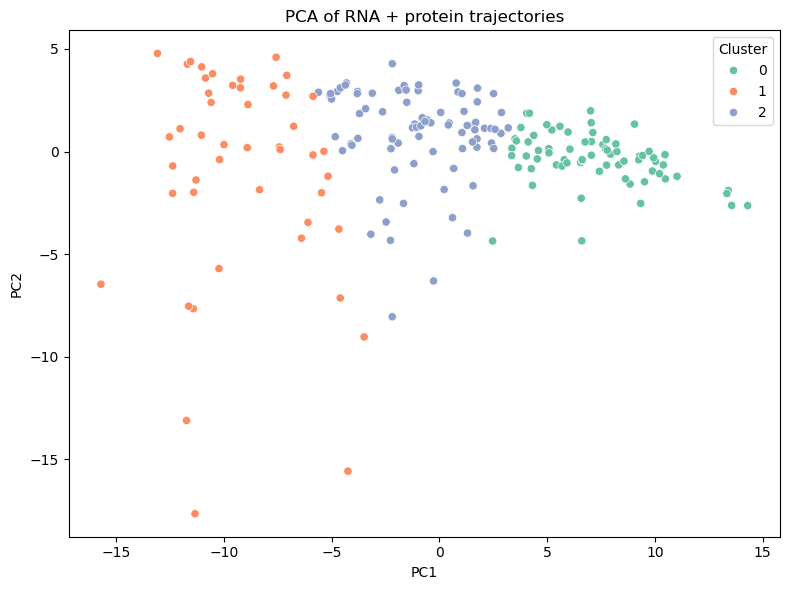

              Cor  Steady_state      Beta     Gamma  Translation_rate  \
Cluster                                                                 
2        0.187166      1.191014  1.703810  0.093528        225.779748   
0        0.287824      4.869444  1.591567  0.073593        275.457022   
1        0.536743      0.507464  1.682065  0.108428        257.964717   

         Degradation_rate   Alpha 1   Alpha 2   Alpha 3       PC1       PC2  
Cluster                                                                      
2                0.020921  1.955717  1.908868  1.932776 -0.939579  0.886992  
0                0.043806  2.105183  2.312957  2.762983  7.220320 -0.350508  
1                0.040804  2.357749  2.448632  3.138441 -9.094412 -1.044356  


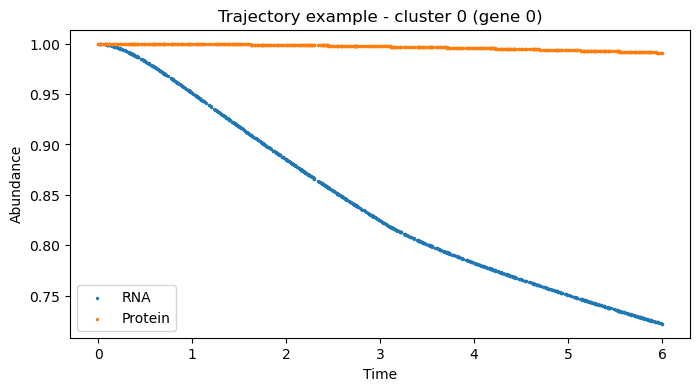

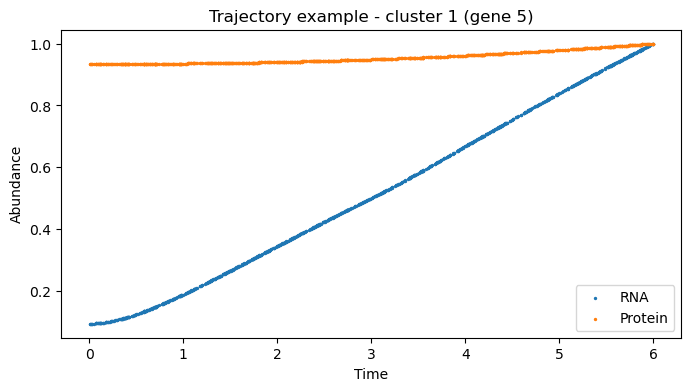

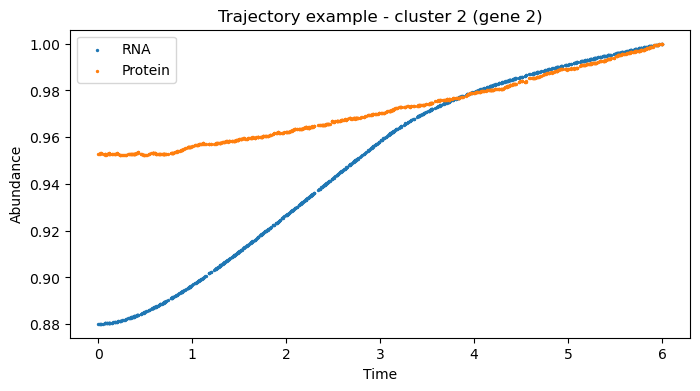

In [21]:
# PCA on genes 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = Y_observed[:,:,1] / np.max(Y_observed[:,:,1], axis=0)
P_norm = P_observed / np.max(P_observed, axis=0)

# === Step 2: Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=0)
pca = PCA(n_components=3)
traj_pca = pca.fit_transform(combined_traj.T)

# === Step 3: Clustering ===
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PC1'] = traj_pca[:,0]
data['PC2'] = traj_pca[:,1]

# === Step 4: Visualization ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='PC1', y='PC2', data=data, hue='Degradation_rate')
# plt.title('PCA of RNA + protein trajectories')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cluster', palette='Set2')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# === Step 5: Correlation Summary by Cluster ===
print(data.groupby('Cluster').mean().sort_values('Cor'))

# Plot representative gene trajectories from each cluster
for c in sorted(data['Cluster'].unique()):
    idx = data[data['Cluster'] == c].index[0]  # random gene in cluster
    plt.figure(figsize=(8, 4))
    plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), label='RNA', s=2)
    plt.scatter(true_t[true_l == 0], P[:n,idx] / np.max(P[:n,idx]), label='Protein', s=2)
    plt.title(f'Trajectory example - cluster {c} (gene {idx})')
    plt.xlabel('Time')
    plt.ylabel('Abundance')
    plt.legend()
    plt.show()

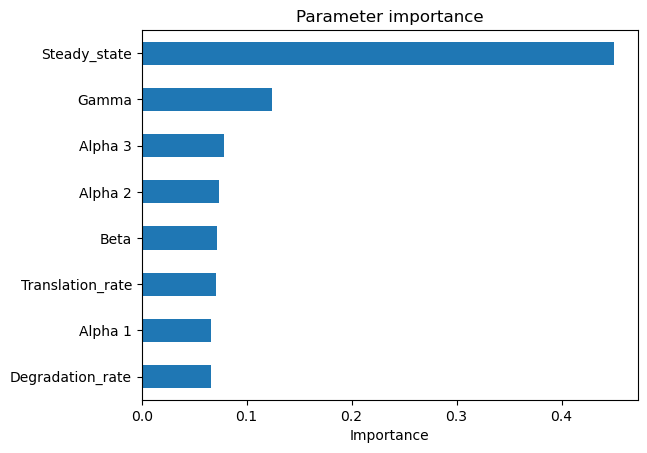

In [160]:
from sklearn.ensemble import RandomForestClassifier

X_params = data[param_cols]
y_clusters = data['Cluster']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_params, y_clusters)

importances = pd.Series(clf.feature_importances_, index=param_cols)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Parameter importance")
plt.xlabel("Importance")
plt.show()

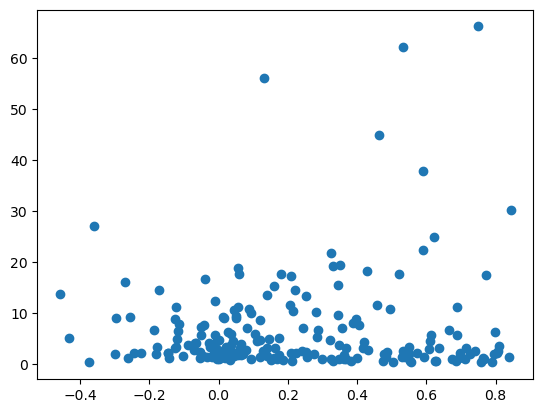

In [165]:
plt.scatter(data['Cor'], data['Steady_state'])

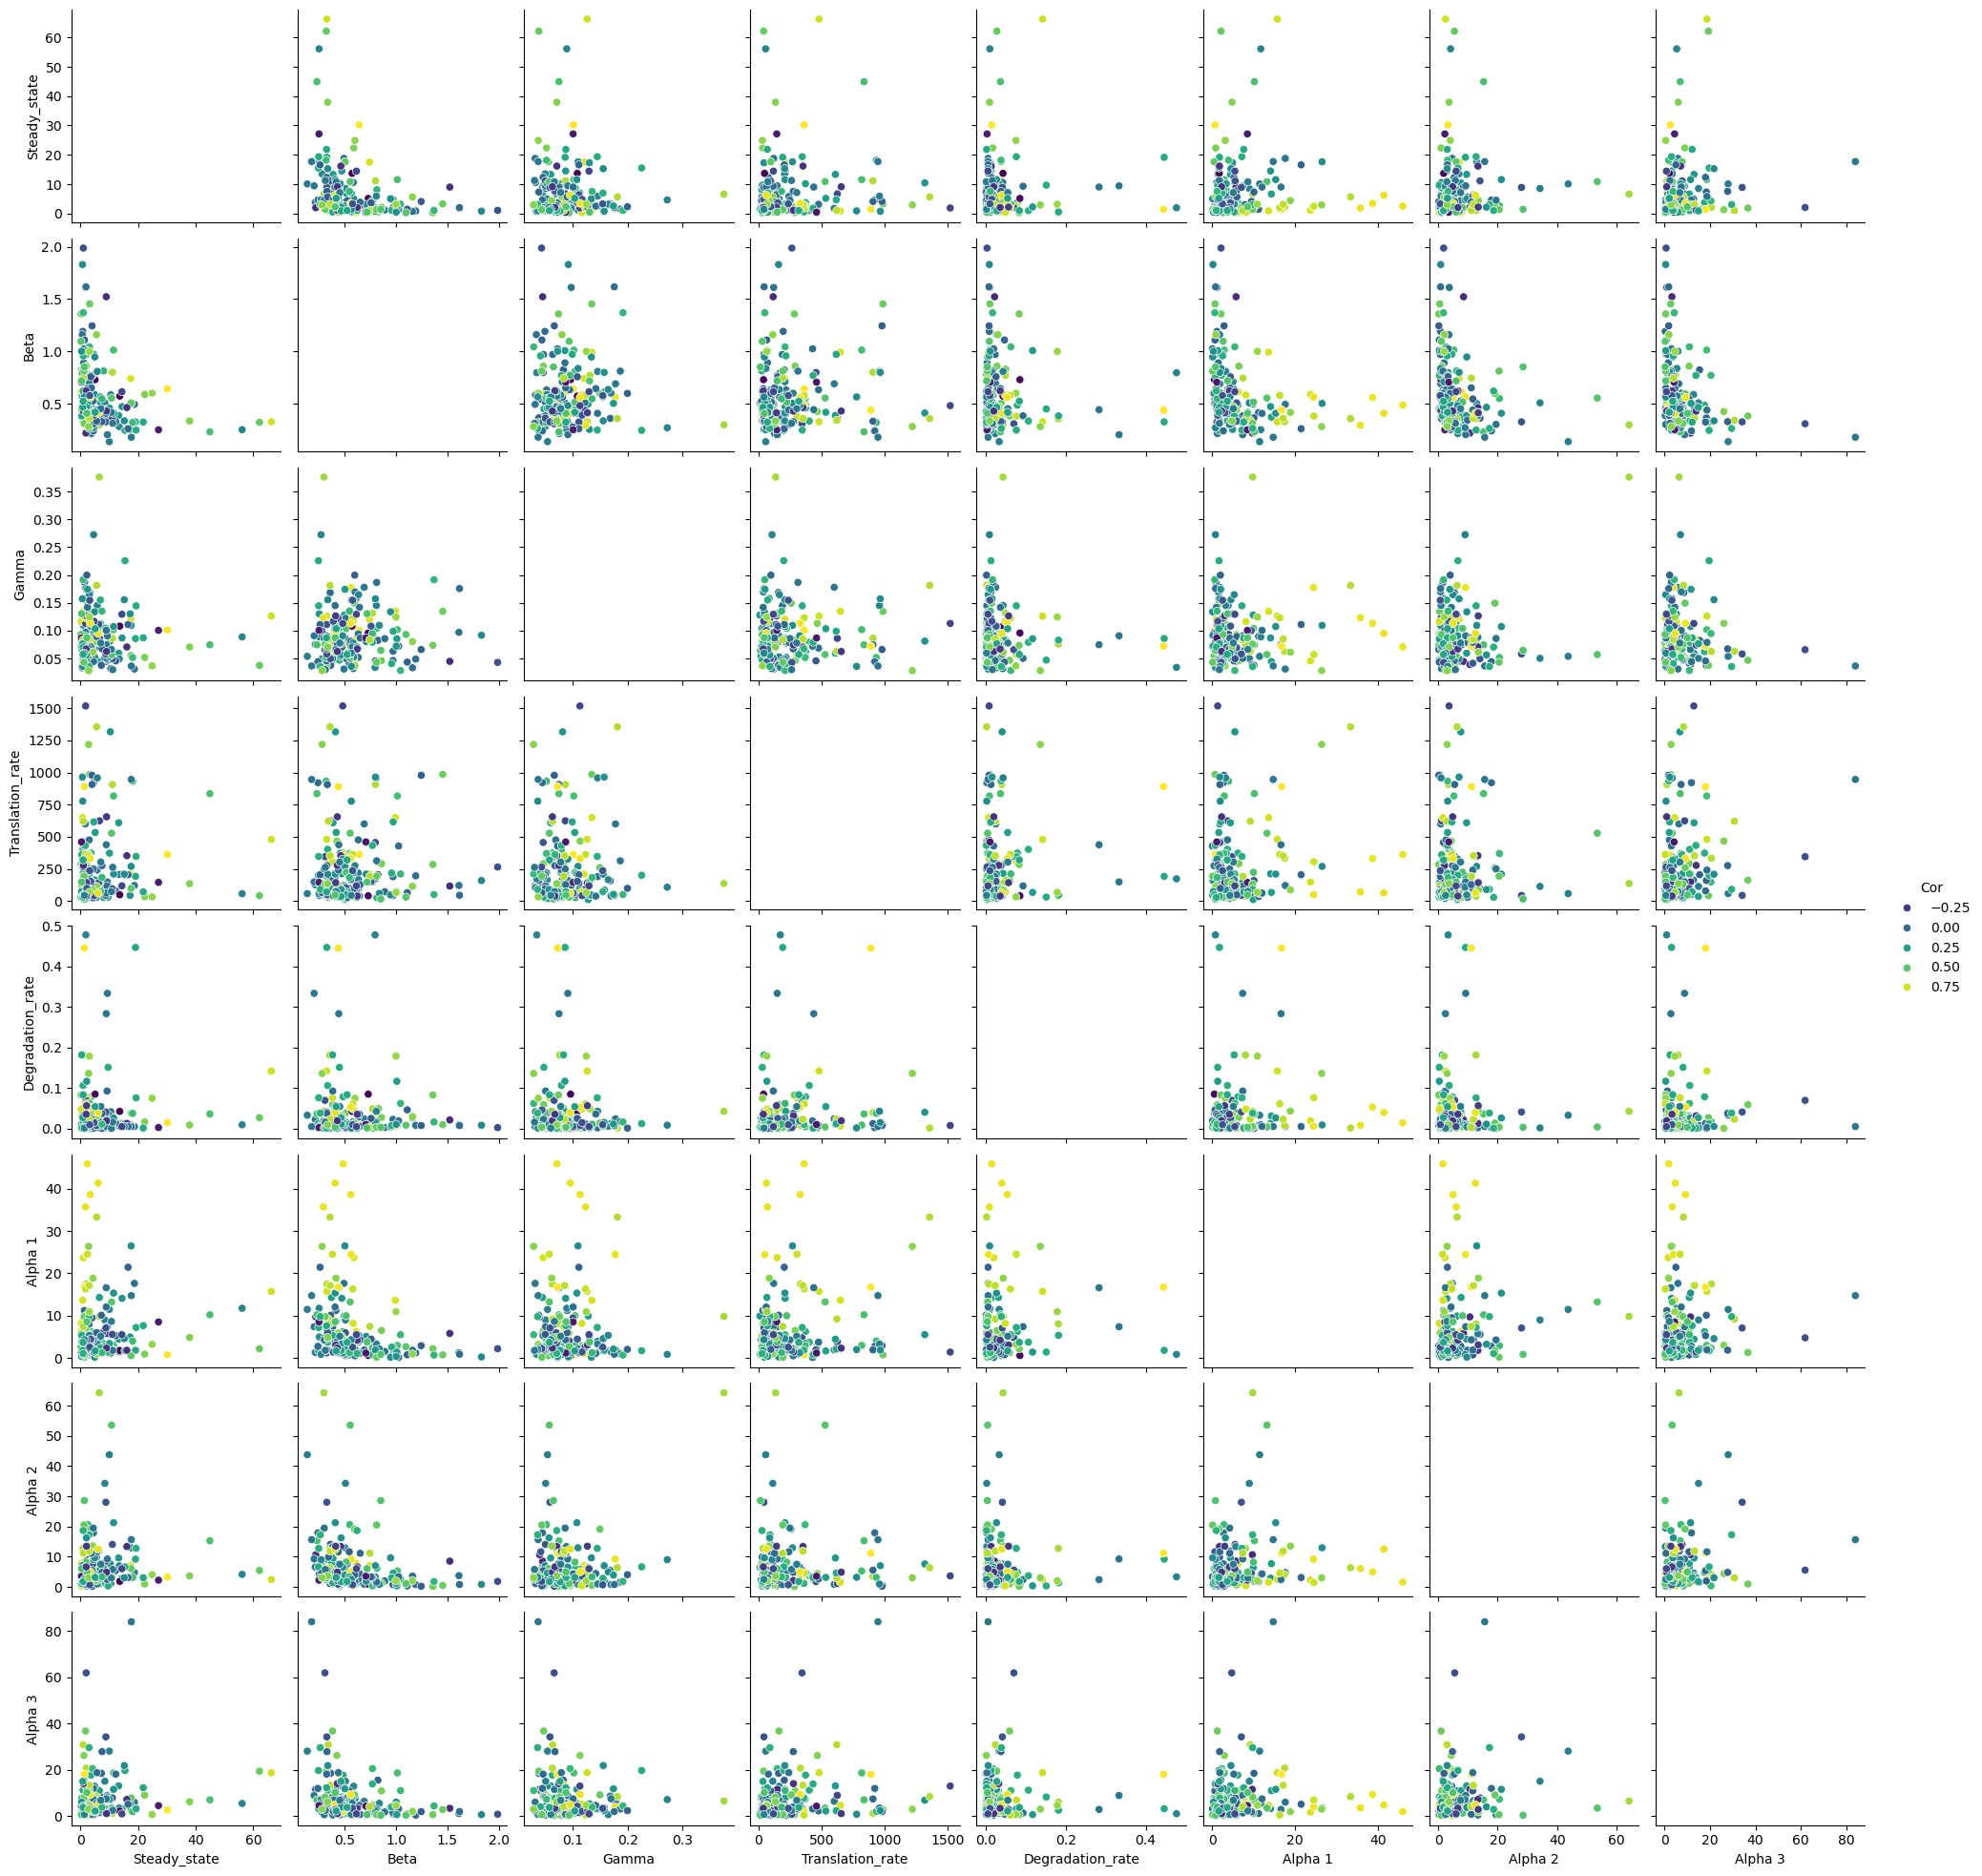

In [161]:
sns.pairplot(data, vars=param_cols, hue='Cor', palette='viridis')

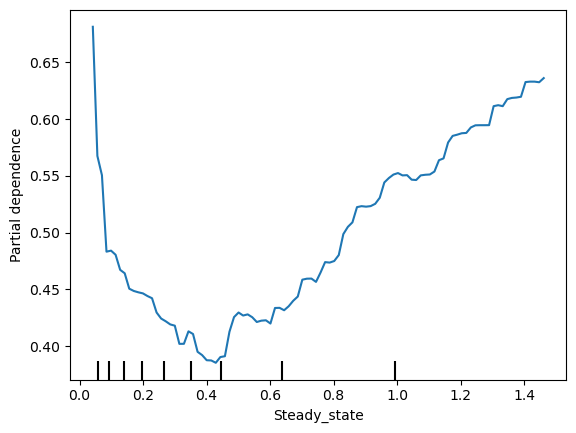

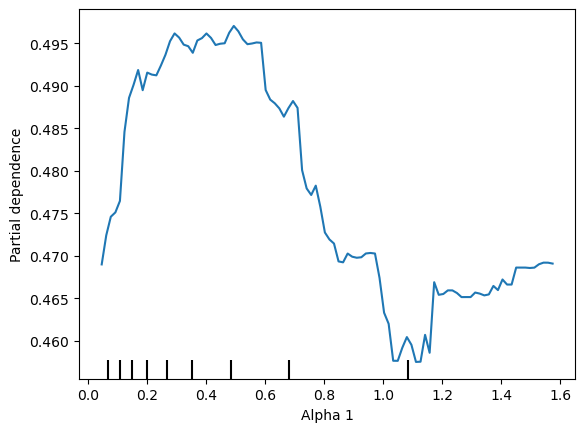

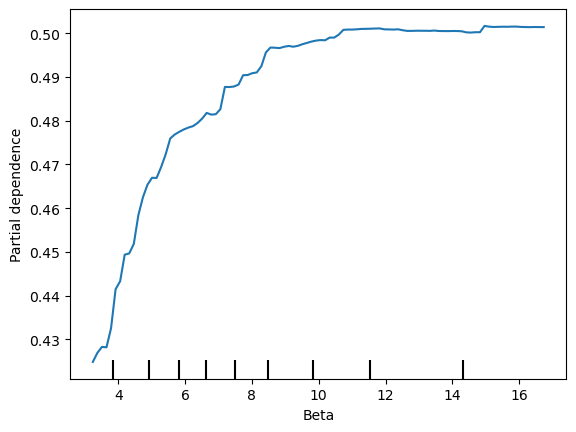

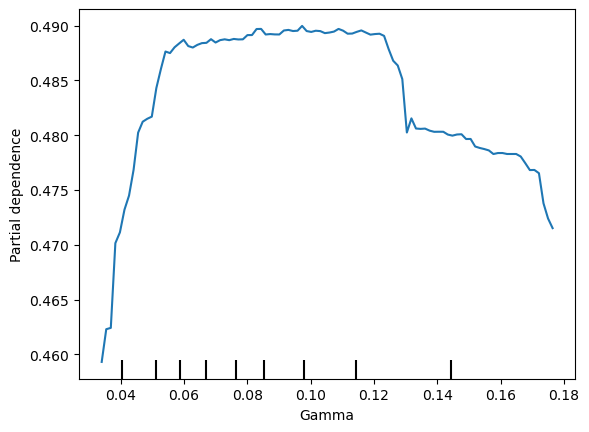

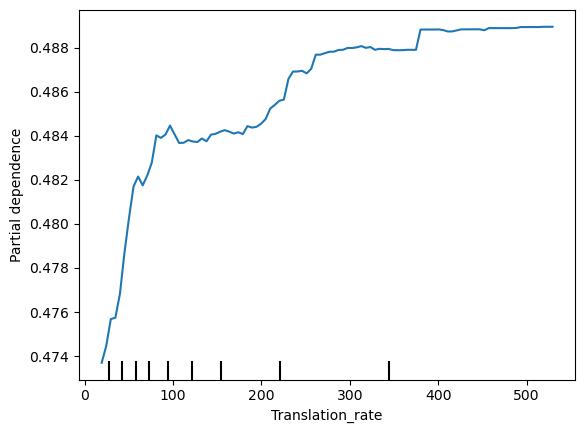

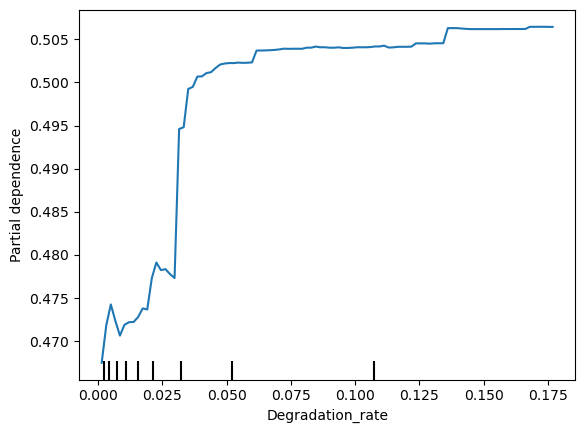

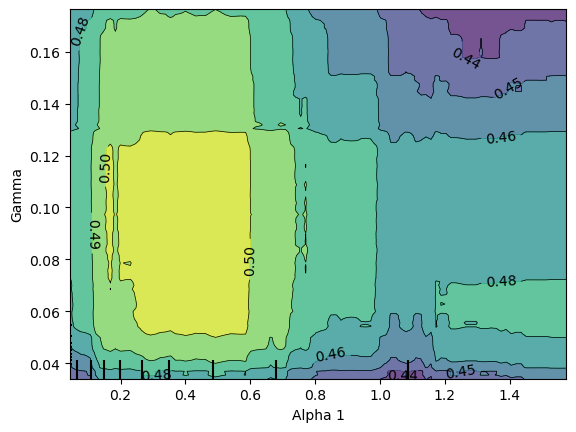

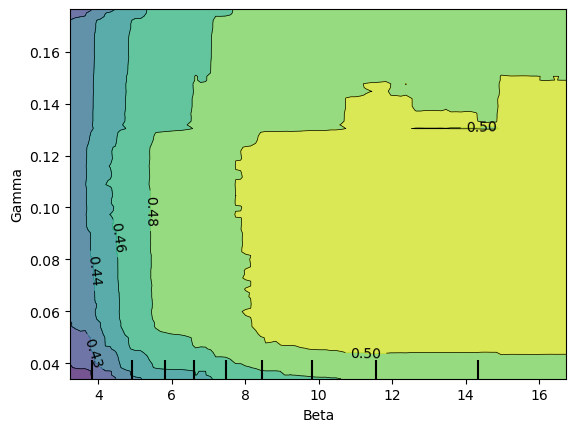

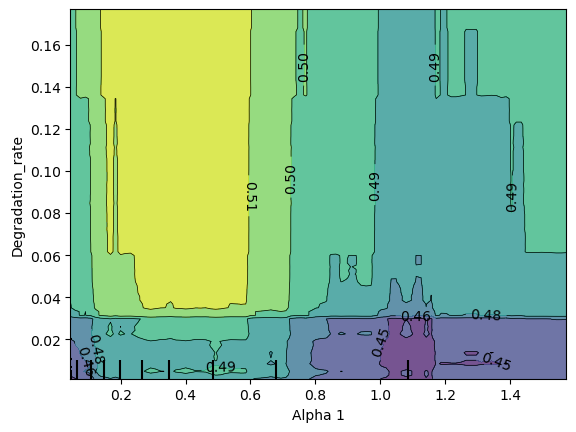

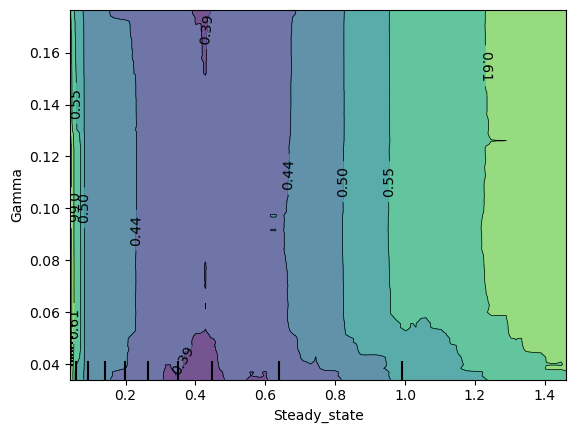

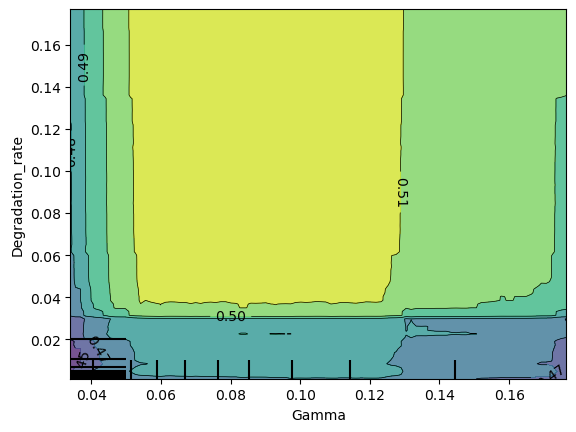

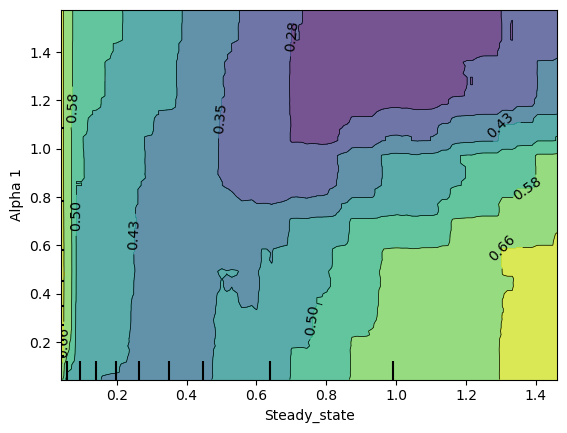

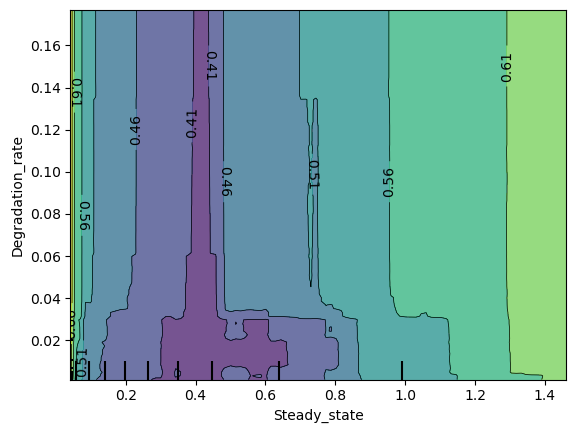

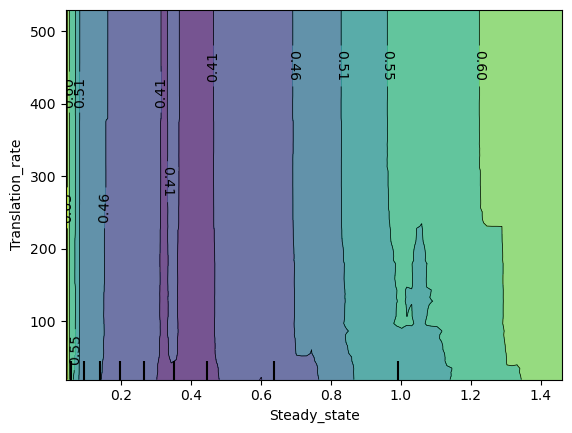

In [280]:
from sklearn.inspection import PartialDependenceDisplay

X = data[param_cols]
y = data['Cor']

model = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols), random_state=0)
model.fit(X, y)

# PDP plots

PartialDependenceDisplay.from_estimator(model, X, features=['Steady_state'])
PartialDependenceDisplay.from_estimator(model, X, features=['Alpha 1'])
PartialDependenceDisplay.from_estimator(model, X, features=['Beta'])
PartialDependenceDisplay.from_estimator(model, X, features=['Gamma'])
PartialDependenceDisplay.from_estimator(model, X, features=['Translation_rate'])
PartialDependenceDisplay.from_estimator(model, X, features=['Degradation_rate'])

PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha 1', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Beta', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Alpha 1', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Gamma')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Gamma', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Alpha 1')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Degradation_rate')])
PartialDependenceDisplay.from_estimator(model, X, features=[('Steady_state', 'Translation_rate')])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = data[param_cols]
y = data['Cor']

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Generate polynomial interaction features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Get interaction term names
feature_names = poly.get_feature_names_out(X.columns)  # X must be a DataFrame
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

# Make predictions
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Gamma Alpha 1                   -1.465908
Gamma Alpha 3                    1.414268
Gamma Degradation_rate           1.265081
Degradation_rate                -0.552040
Degradation_rate Alpha 3         0.510879
Steady_state                     0.398816
Degradation_rate Alpha 2        -0.269143
Steady_state Alpha 1            -0.252694
Gamma                            0.227781
Steady_state Degradation_rate   -0.167656
Degradation_rate Alpha 1         0.130944
Alpha 1                          0.122564
Alpha 2 Alpha 3                 -0.110348
Beta Degradation_rate            0.099591
Steady_state Alpha 2            -0.088639
dtype: float64
Mean Squared Error: 0.0715381607255353
R-squared: 0.21644404054193123


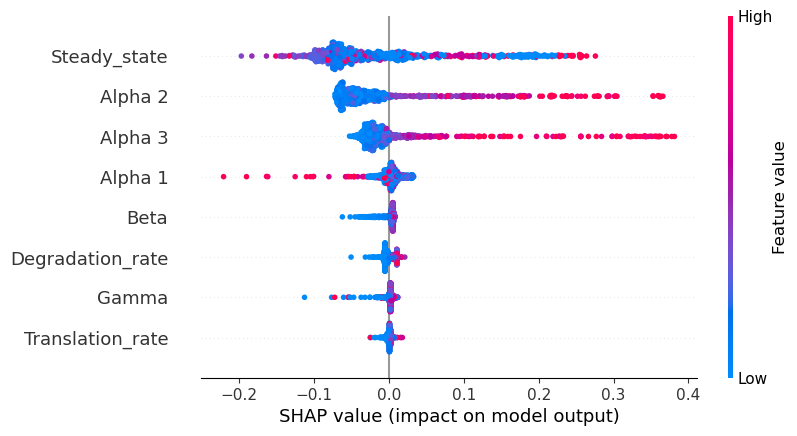

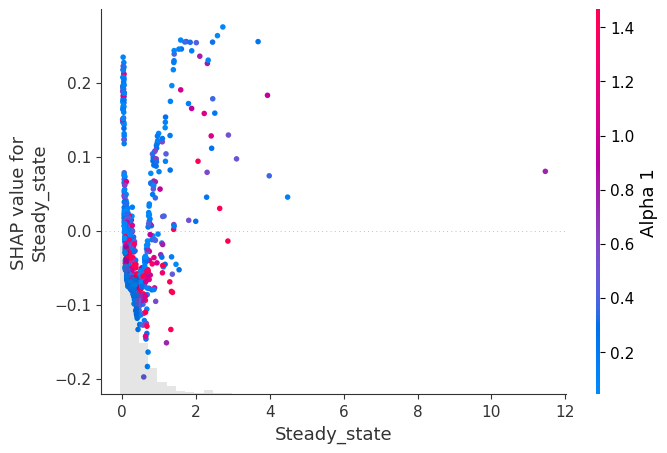

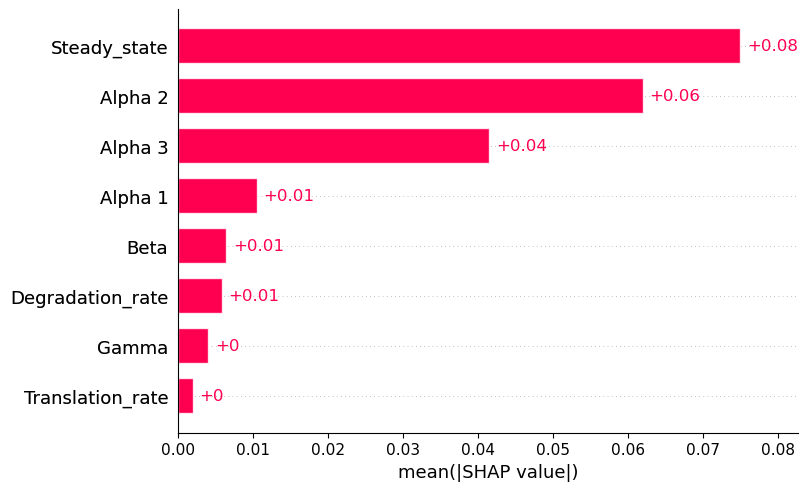

In [283]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Prepare features and target
X = data[param_cols]
y = data['Cor']

# 2. Train/test split (optional but recommended for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Fit Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

# 4. Create SHAP explainer with new API
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # Explanation object

# 5. Plot summary (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)

# 6. Plot dependence (e.g. Gamma vs Cor, colored by Translation_rate)
shap.plots.scatter(shap_values[:, "Steady_state"], color=shap_values[:, "Alpha 1"])

# 7. If you want bar plot of mean |SHAP| values:
shap.plots.bar(shap_values, max_display=10)
